# МОДЕЛИРОВАНИЕ СИСТЕМЫ ХРАНЕНИЯ ДАННЫХ

## ОПИСАНИЕ

*Задача проекта (User Story):*

Я, как product owner хочу уметь расчитывать производительность из параметров железа     
Чтобы снизить затраты производства и повысить предсказуемость характеристик продукта

*Критерии приемки:*

* Возможность восстановить параметры железа по производительности

* Модель должна выводить сравнительные графики: сырой даты и предсказанной

* Вывод метрик модели (R², средние квадраты и тд.)



## СОДЕРЖАНИЕ


* Config  
  * Libraries
  * Documentation
  * General view of text size
* Raw data  
  * Reader
  * Converter
  * Writer
  * OHE
* Analysis
  * Distribution
  * Correlation matrix
* Data preprocessing
  * Validation of data
    * Founder
    * Auto purifier
    * Writer of broken sizes
  * Scaling
  * Define weights
  * Visualization post-processed data
    * Correlation matrix
    * Graphs
* Modelling
  * Training
  * Visualization predicted data
  * Metrics
* Summaries - todo
* TODO
   

## Configuration

### Libraries

In [345]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import xarray as xr
import itertools
import seaborn as sns
import random
from sklearn.ensemble import RandomForestRegressor
import re
import glob
import uuid
import copy
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from collections import Counter


In [3]:
folder_path = 'Correct sizes'  # Path of raw data

### Documentation

Фиксируем возможные значения параметров, описываем их тип.

In [4]:
doc = {
       'protection': ['2REP', '3REP', 'EC2.1'],  #cat. # maybe more types later
       'size': [8, 128, 1_000, 128_000],  # cont.
       'nodes': np.linspace(4, 16, 13, dtype = int),  # cont.
       'type': ['write', 'read'],  # cat.
       'HW_chassis': ['X205', 'VEGMAN'],  # cat.
       'SSD': [0, 2, 4]  # cat.
      }

cat_params = ['protection', 'type', 'HW_chassis', 'SSD']
cont_params = ['size', 'nodes']

all_options = np.array(list(itertools.product( *(doc[key] for key in list(doc.keys())) )))

all_options_w_ops = np.concatenate((all_options, [[0] for _ in range(len(all_options))]), axis = 1)


**Установим общий вид .txt / .md файла замера**

```
protection=<protecrion_value>
HW_chassis=<hardware_chassis_value>
SSD=<number_of_ssd>

### <number_of_nodes> nodes <object's_size> <type> // begin of size
INFO[<time>] Load started at: <date> (<timezone>) source=<source_value> 
INFO[<time>] Load finished at: <date> (<timezone>)source=<source_value>   
█ setup

\``` // _begin of block with size results from one installation_
 █ teardown

 aws_obj_put_bytes......: <float> <unit_of_measurement>  <float><unit_of_measurement>/s
 
 aws_obj_put_duration...: avg=<float><unit_of_measurement> min=<float><unit_of_measurement> med=<float><unit_of_measurement> max=<float><unit_of_measurement> p(90)=<float><unit_of_measurement>  p(95)=<float><unit_of_measurement>
 aws_obj_put_success....: <float> <float>/s
 data_received..........: <float> <unit_of_measurement> <float> <unit_of_measurement>/s
 data_sent..............: <float> <unit_of_measurement> <float> <unit_of_measurement>/s
 iteration_duration.....: avg=<float><unit_of_measurement> min=<float><unit_of_measurement> med=<float><unit_of_measurement> max=<float><unit_of_measurement> p(90)=<float><unit_of_measurement>  p(95)=<float><unit_of_measurement>
 iterations.............: <float> <float>/s
 vus....................: <float> min=<float> max=<float>
\``` // _end of block with size results from one installation_
// there can be several blocks for one size
```

## Raw data

### Reader

Скрипт читает все файлы замеров и переводит замеры в словарь ```Data```, в котором ключи --- параметры железа.

**python-dict Data**
```python
Data: {
    id: body
}
id = str(uuid.uuid4()) 
```  

**json-объект "body"**
```json
body: {
    "system": {
        "patch": "str",
        "index": "int"
    },
    "parametrs": {
        "protection": "str",
        "size": "int",
        "nodes": "int",
        "type": "str",
        "HW_chassis": "str",
        "SSD": "int"
    },
    "values": {
        "straight": {
            "MB/s": "list",
            "avg": "list",
            "min": "list",
            "med": "list",
            "max": "list",
            "p(90)": "list",
            "p(95)": "list",
            "op/s": "list",
            "op/s_loss": "list"
        },
        "agregated": {
            "SUM_MB/s": "float",
            "SUM_op/s": "float"
        }
    }
}
```

В качестве таргет-валью берём body/values/agregated/SUM_op/s

In [5]:
body_template = {
    "system": {
        "patch": None,
        "index": None
    },
    "parametrs": {
        "protection": None,
        "size": None,
        "nodes": None,
        "type": None,
        "HW_chassis": None,
        "SSD": None
    },
    "values": {
        "straight": {
            "MB/s": [],
            "avg": [],
            "min": [],
            "med": [],
            "max": [],
            "p(90)": [],
            "p(95)": [],
            "op/s": [],
            "op/s_loss": []
        },
        "agregated": {
            "SUM_MB/s": None,
            "SUM_op/s": None
        }
    }
}

In [6]:
txt_files = glob.glob(f"{folder_path}/*.txt")
md_files = glob.glob(f"{folder_path}/*.md")

all_files = txt_files + md_files
global_counter_correct = 0
global_counter_get = 0

Data = dict()

for file_path in all_files:
    with open(file_path, 'r', encoding='utf-8') as file:
        
        ###
        lines = file.readlines()
        data = []
        for line in lines:
            data.append( line.strip().split(' ') )


        file_protection = [temp_data[0].split('=')[1].upper() for temp_data in data if 'protection' in temp_data[0]][0]
 
        file_HW_chassis = [temp_data[0].split('=')[1].upper() for temp_data in data if 'HW_chassis' in temp_data[0]][0]

        file_SSD = [int(temp_data[0].split('=')[1]) for temp_data in data if 'SSD' in temp_data[0]][0]
  
        i = 0
        counter = 0
        global_counter_correct += str(data).count('###')
        print(str(data).count('###'),f'correct number of sizes {file_path}')
        # realization of data reading functions
        while i < len(data):
            
            if '###' in data[i]:
                index = 0
                counter += 1

                body_size = copy.deepcopy(body_template)
                
                Params = dict.fromkeys(list(doc.keys()))
                for temp in list( Params.keys() ):
                    Params[temp] = 0
                
                temp_data_0 = [k for k in data[i] if len(k) > 0]

                id_size = str(uuid.uuid4()) 

                #  записываем конфиг замера
                body_size["system"]["patch"] = file_path
                body_size["parametrs"]["protection"] = file_protection
                body_size["parametrs"]["nodes"] = int(temp_data_0[1])
                body_size["parametrs"]["SSD"] = file_SSD
                body_size["parametrs"]["type"] =  temp_data_0[4].lower()
                body_size["parametrs"]["HW_chassis"] = file_HW_chassis
                
                if re.fullmatch( r'(\b\d*kb\b)', str( temp_data_0[3] ).lower()):  # size like kb
                    body_size["parametrs"]["size"] = int(temp_data_0[3][:-2])
                elif re.fullmatch( r'(\b\d*kib\b)', str( temp_data_0[3] ).lower() ):  #size like kib
                    body_size["parametrs"]["size"] = int(temp_data_0[3][:-3])
                elif re.fullmatch( r'(\b\d*mb\b)', str( temp_data_0[3] ).lower() ):  #size like mb
                    body_size["parametrs"]["size"] = int(temp_data_0[3][:-2]) * 1000  # convert to KB
                elif re.fullmatch( r'(\b\d*mib\b)', str( temp_data_0[3] ).lower() ):  #size like mib
                    body_size["parametrs"]["size"] = int(temp_data_0[3][:-3]) * 1000
                else:
                    body_size["parametrs"]["size"] = 'INCORRECT DATA'

                i += 1
                
                # пишем фичи замера
                while i < len(data) - 1 and not('###' in data[i+1]):
                    
                    if 'aws_obj_get_bytes' in str(data[i]) or 'aws_obj_put_bytes' in str(data[i]):
                        temp_data = [k for k in data[i] if len(k) > 0]
                        if str(temp_data[-1]).lower() == 'mb/s':
                            body_size["values"]["straight"]["MB/s"].append(float(temp_data[-2]))
                        elif str(temp_data[-1]).lower() == 'gb/s':
                            body_size["values"]["straight"]["MB/s"].append(float(temp_data[-2]) * 1000)  # convert to mb/s
                        else:
                            body_size["values"]["straight"]["MB/s"].append('INCORRECT DATA')
                    
                    if 'aws_obj_get_duration' in str(data[i]) or 'aws_obj_put_duration' in str(data[i]):
                        temp_data = [k.split('=') for k in data[i] if len(k) > 0]
                        for j in range(1,6+1):                            
                            if 'ms' in str(temp_data[j][1]).lower():  # case M.SECONDS
                                body_size["values"]["straight"][temp_data[j][0]].append(float(temp_data[j][1][:-2]))  # we suppose that notation <digits>m<digits><MS> is impossible 
                                    
                            else:  # case SECONDS 
                                match = re.fullmatch( r'(\b\d*\dm\d\d*\w*\b)', str(temp_data[j][1]).lower() )  # <digits (at least 1)>m<digits (at least 1)><s> - found m in d[b][1] in seconds
                                if match:
                                    body_size["values"]["straight"][temp_data[j][0]].append((float(str(temp_data[j][1][:-1]).split('m')[0]) * 60 + float(str(temp_data[j][1][:-1]).split('m')[1])) * 1000)  # convert to ms| found m
                                else:
                                    body_size["values"]["straight"][temp_data[j][0]].append(float(temp_data[j][1][:-1]) * 1000)  # convert to ms
            
                    if 'aws_obj_put_success' in str(data[i]) or 'aws_obj_get_success' in str(data[i]):
                        temp_data = [k for k in data[i] if len(k) > 0]
                        body_size["values"]["straight"]['op/s'].append(float(temp_data[2][:-2:]))  #obj/s
                        
            
                    if 'aws_obj_get_fails' in str(data[i]):
                        temp_data = [k for k in data[i] if len(k) > 0]
                        body_size["values"]["straight"]['op/s_loss'].append(float(temp_data[2][:-2:]))  #obj/s
                    i += 1
                ### found '###' or end of file, update our Data                    
                
                # realization of agregate functions 
                body_size["values"]["agregated"]['SUM_MB/s'] = np.sum(body_size["values"]["straight"]['MB/s'])
                body_size["values"]["agregated"]['SUM_op/s'] = np.sum(body_size["values"]["straight"]['op/s'])
                
                ###
                Data[id_size] = body_size
                body_size = {}
            i += 1
                        
    print(counter, f'get number of sizes {file_path}')
    global_counter_get += counter

print(f'summary get points = {global_counter_get}\n', f'summary correct points = {global_counter_correct}')
print(f'length of Data (processed data) = {len(Data)}')

max_index = max([key[0] for key in list(Data.keys())])


39 correct number of sizes Correct sizes\Sizer results for rep3.txt
39 get number of sizes Correct sizes\Sizer results for rep3.txt
61 correct number of sizes Correct sizes\Sizer_results_1.txt
61 get number of sizes Correct sizes\Sizer_results_1.txt
56 correct number of sizes Correct sizes\sizer_results_16nodes_ec2.1_12_2.md
56 get number of sizes Correct sizes\sizer_results_16nodes_ec2.1_12_2.md
48 correct number of sizes Correct sizes\sizer_results_16nodes_rep2_12_0.md
48 get number of sizes Correct sizes\sizer_results_16nodes_rep2_12_0.md
62 correct number of sizes Correct sizes\sizer_results_16nodes_rep2_12_2.md
62 get number of sizes Correct sizes\sizer_results_16nodes_rep2_12_2.md
39 correct number of sizes Correct sizes\sizer_results_16nodes_rep3_12_2.md
39 get number of sizes Correct sizes\sizer_results_16nodes_rep3_12_2.md
24 correct number of sizes Correct sizes\sizer_results_8nodes_ec2.1_12_4.md
24 get number of sizes Correct sizes\sizer_results_8nodes_ec2.1_12_4.md
40 corre

### Writer

Записывает ```Data_list``` в .xlsx файл.

In [7]:
df_out = pd.DataFrame(body_template["system"] | body_template["parametrs"] | body_template["values"]["straight"] | body_template["values"]["agregated"])
for id in list(Data.keys()):
    values_temp = {key: [value] for key, value in Data[id]["values"]["straight"].items()}
    new_row = pd.DataFrame(Data[id]["system"] | Data[id]["parametrs"] | values_temp | Data[id]["values"]["agregated"], index=[id])
    df_out = pd.concat([df_out, new_row])

df_out.to_excel('output.xlsx', header=True)


C:\Users\shiri\AppData\Local\Temp\ipykernel_2316\536954027.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_out = pd.concat([df_out, new_row])


### One Hot Encoder

Переводит строковые категориальные признаки в унитарные.

In [ ]:
def features_transformation(df_out: pd.DataFrame, doc = doc) -> pd.DataFrame:  # CHECK CODE AFTER EVERY UPDATE!
    '''
    df_out должен содержать колонки `list(doc.keys()) + ["SUM_op/s"]`
    '''
    header = list(doc.keys()) + ["SUM_op/s"]
    df_operational = df_out[header]
    indexes_temp = np.linspace(0, len(all_options_w_ops)-1, len(all_options_w_ops), dtype=int)
    doc_df = pd.DataFrame(all_options_w_ops, columns=header, index=indexes_temp)
    df_operational = pd.concat([df_operational, doc_df])
    # define types
    df_operational["size"] = df_operational["size"].astype(int)
    df_operational["nodes"] = df_operational["nodes"].astype(int)
    df_operational["SSD"] = df_operational["SSD"].astype(int)

    df_operational = pd.get_dummies(df_operational, columns=cat_params, prefix=cat_params)
    df_operational = df_operational.drop(indexes_temp)
    df_operational = df_operational.replace({True: 1, False: 0}).infer_objects(copy=False)
    return df_operational.drop(['protection_2REP', 'type_read', 'HW_chassis_VEGMAN', 'SSD_2'], axis=1, inplace=False)  # drop collinear columns


In [9]:
df = features_transformation(df_out)

C:\Users\shiri\AppData\Local\Temp\ipykernel_2316\3629461837.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_operational = df_operational.replace({True: 1, False: 0}).infer_objects(copy=False)


In [10]:
features_transformation(df_out).to_excel("data_after_OHE.xlsx", header=True)


C:\Users\shiri\AppData\Local\Temp\ipykernel_2316\3629461837.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_operational = df_operational.replace({True: 1, False: 0}).infer_objects(copy=False)


## Analysis

In [11]:
def compare (key: tuple, parametr: str, fix_params: dict) -> bool:
    i = 0
    while str(parametr) != str(list(fix_params.keys())[i]):
        if str(key[i]) != str(list(fix_params.values())[i]):
            return 0
            break
        i += 1
    i += 1
    while i < len(list(fix_params.keys())):
        if str(key[i]) != str(list(fix_params.values())[i]):
            return 0
            break
        i += 1
    return 1

def key_enum (param: str, doc = doc):
    i = 0
    while i < len(list(doc.keys())):
        if str(param) == str(list(doc.keys())[i]):
            return i
            break
        i += 1
    return 'ERROR'

#### Distribution

C:\Users\shiri\AppData\Local\Temp\ipykernel_2316\485678001.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\shiri\AppData\Local\Temp\ipykernel_2316\485678001.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\shiri\AppData\Local\Temp\ipykernel_2316\485678001.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\shiri\AppData\Local\Temp\ipykernel_2316\485678001.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legen

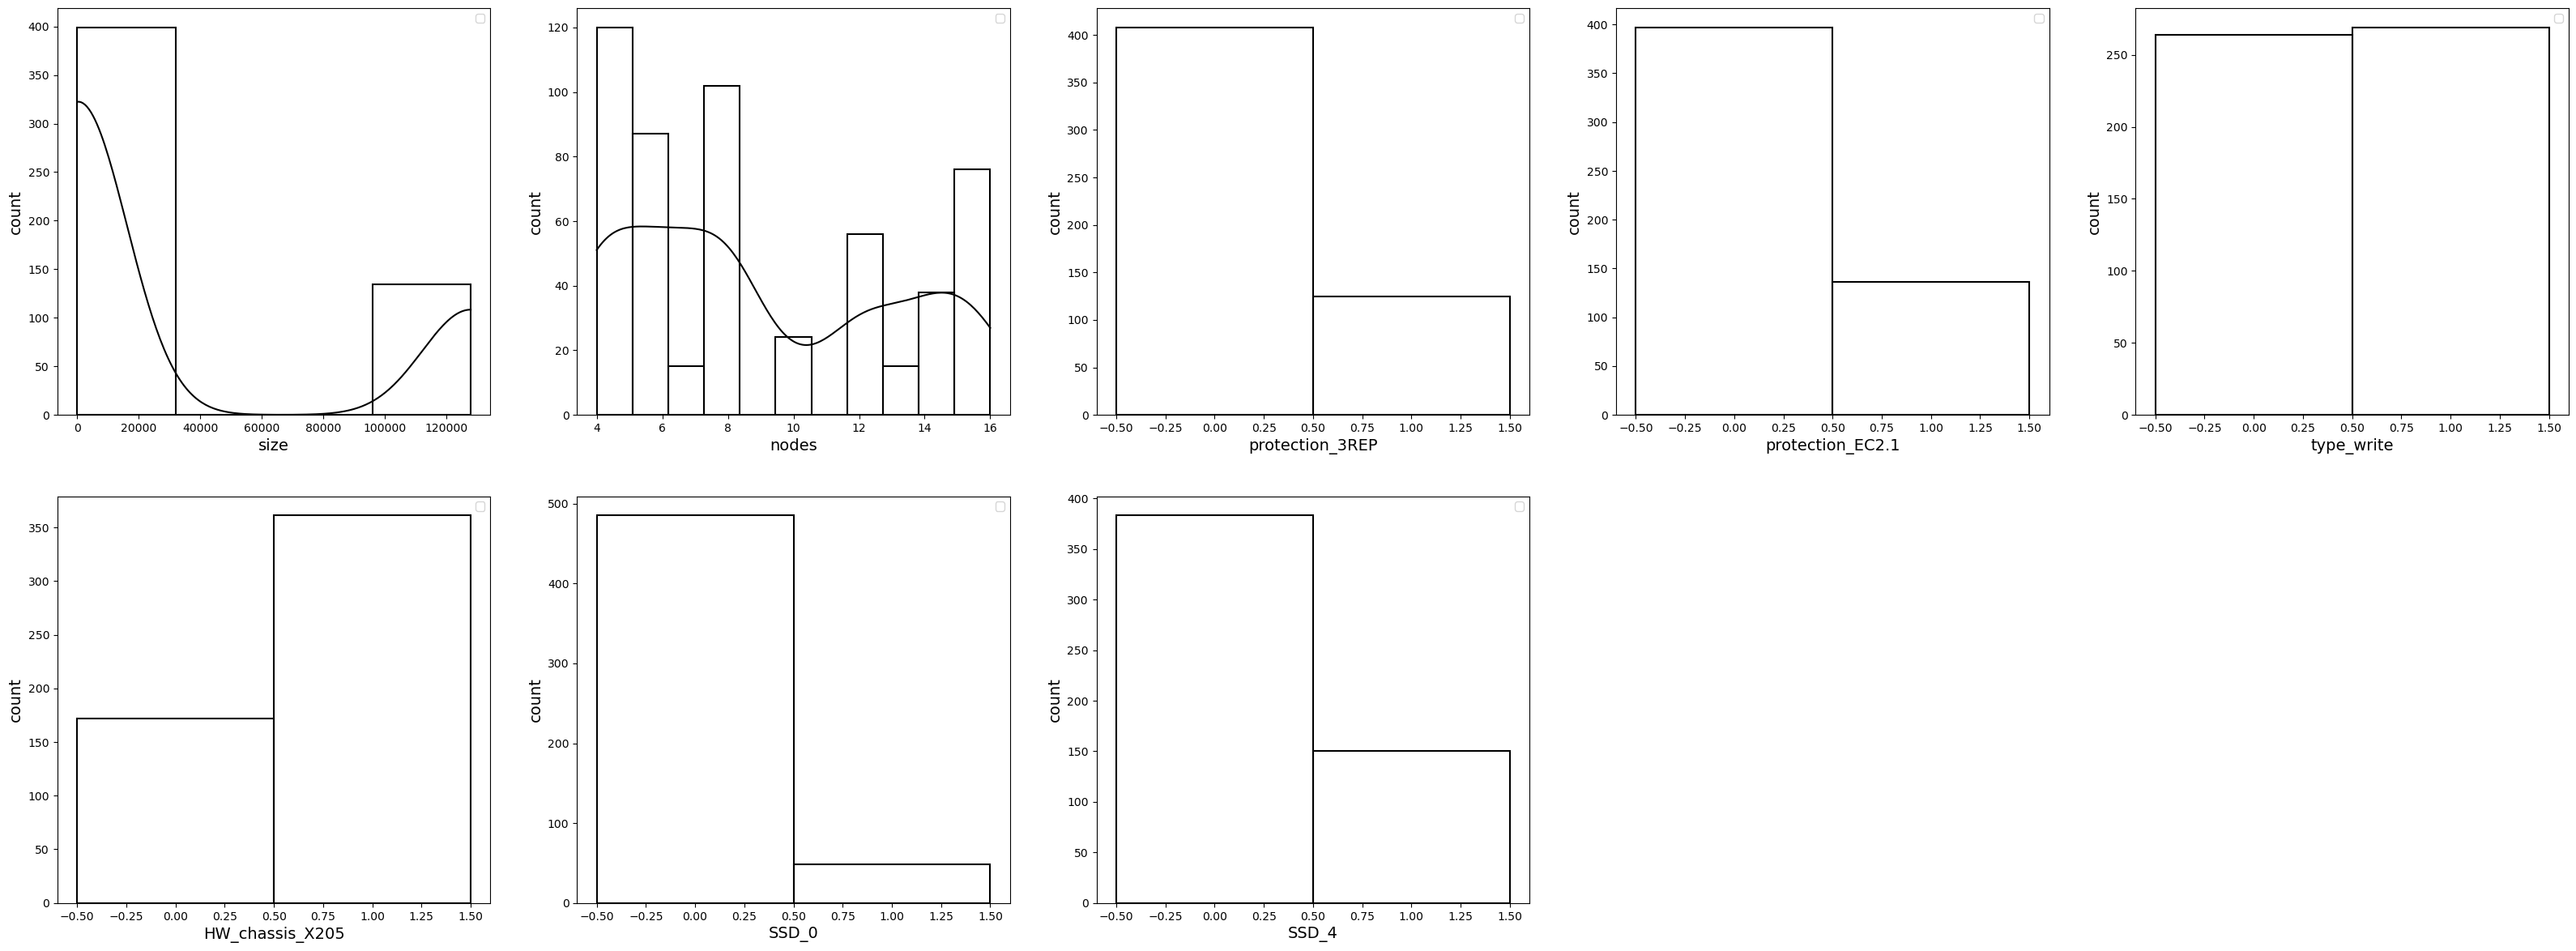

In [12]:
plt.figure(figsize=(40,30))
header_temp = list(df.columns)
header_temp.remove('SUM_op/s')
n = len(header_temp)

for i in range(n):
    plt.subplot(n // 2, n - n // 2 + 1,i + 1)
    X = list(df[header_temp[i]])
    Y = list(df['SUM_op/s'])
    n_bins = len(list(df[header_temp[i]].unique()))
    cont_switch = True if (header_temp[i] in cont_params) else False 
    his = sns.histplot(X, bins=n_bins, color='k', kde=cont_switch, fill=False, discrete=(not cont_switch))
    plt.title('', fontsize=15)
    plt.xlabel(header_temp[i], fontsize=14, color='k')
    plt.ylabel('count', fontsize=14, color='k')
    plt.legend()
plt.show()
sns.reset_orig()


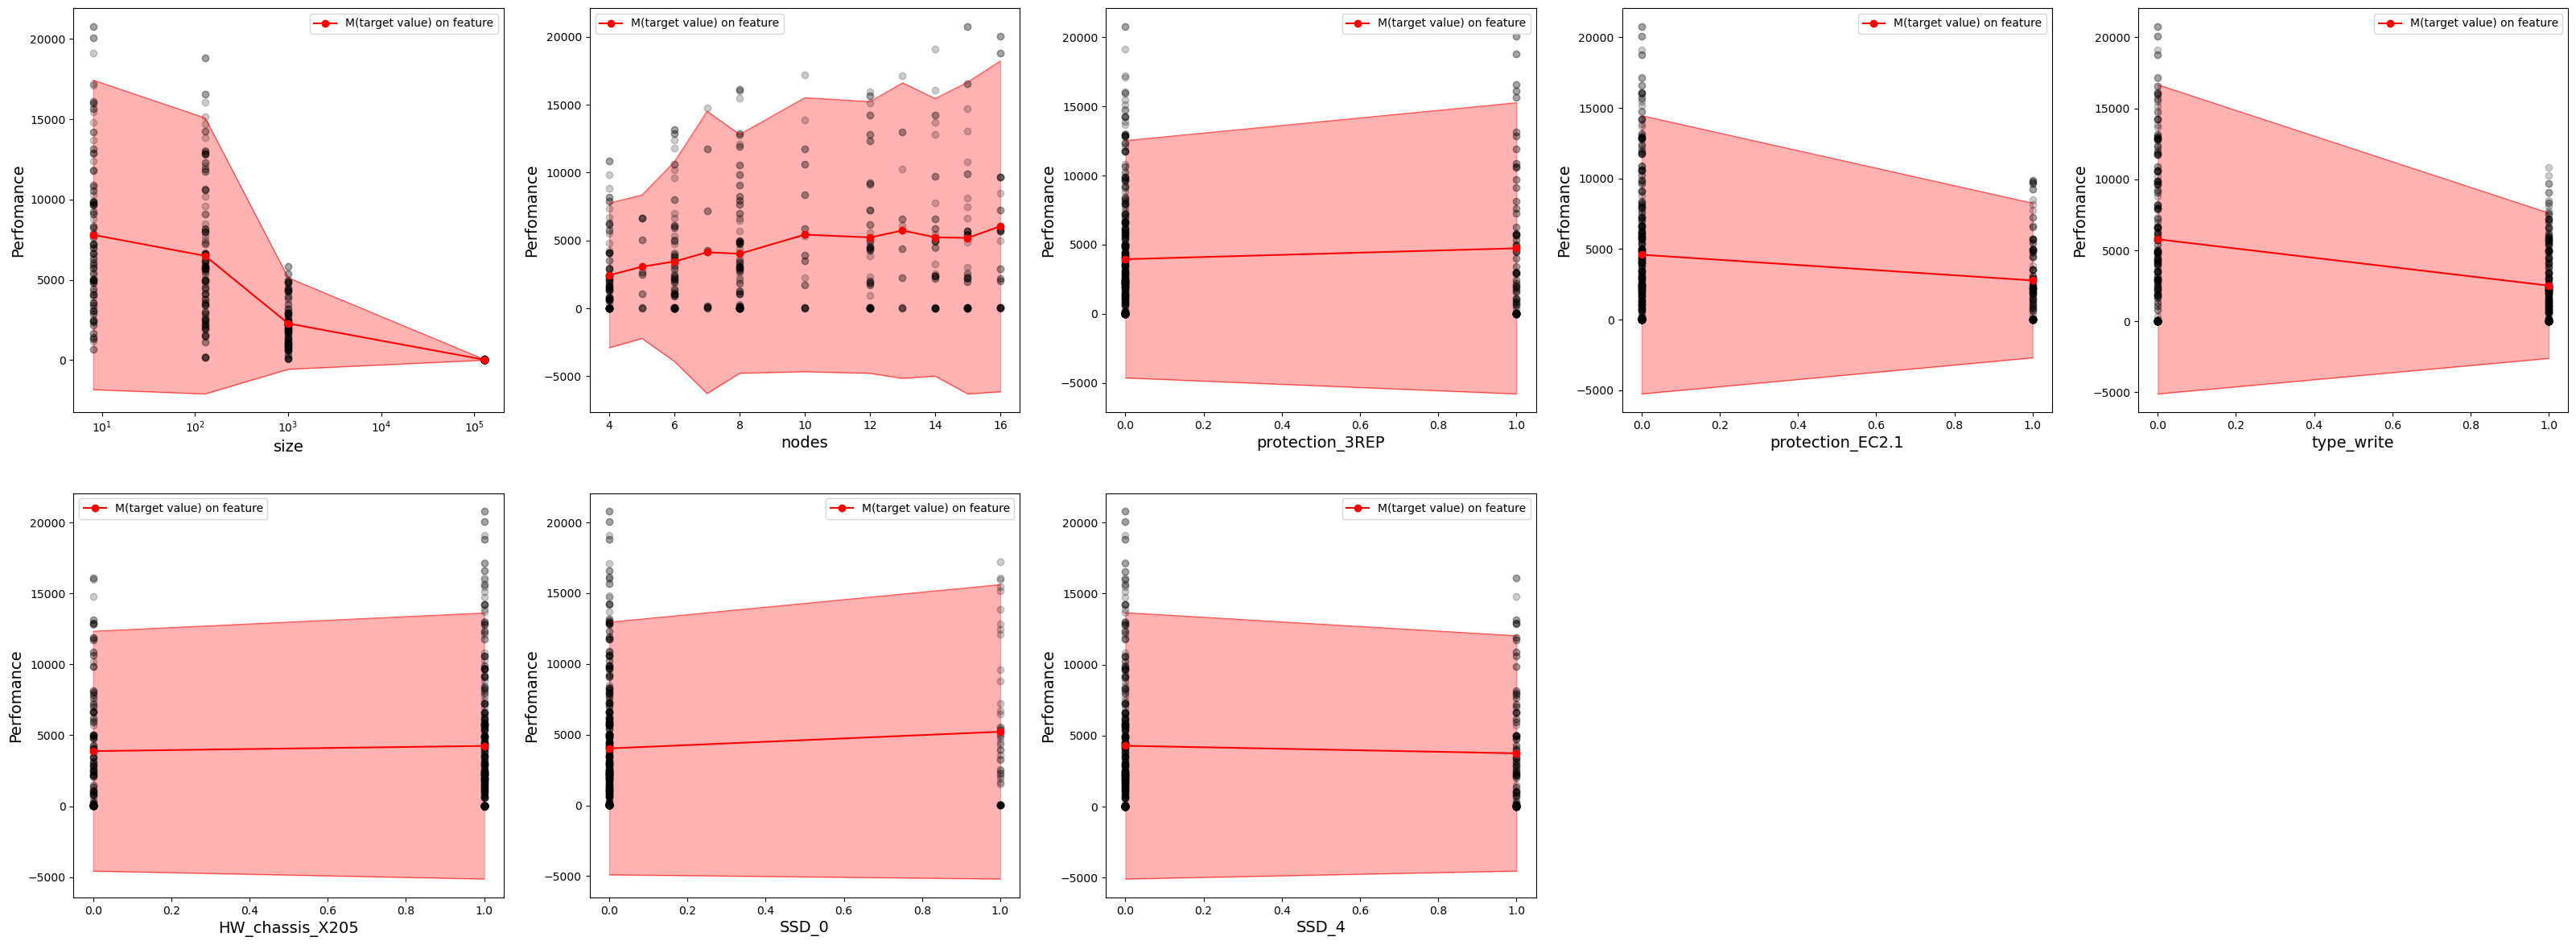

In [13]:
plt.figure(figsize=(40,30))
header_temp = list(df.columns)
header_temp.remove('SUM_op/s')
n = len(header_temp)
for i in range(n):
    plt.subplot(n // 2, n - n // 2 + 1,i + 1)
    if header_temp[i] == 'size':
        plt.xscale('symlog')
    else:
        plt.xscale('linear')
    X = list(df[header_temp[i]])
    Y = list(df['SUM_op/s'])
    mean_values = df.groupby(header_temp[i])['SUM_op/s'].mean().reset_index()
    mean_values.columns = ['X', 'Mean_Y']
    var_values = df.groupby(header_temp[i])['SUM_op/s'].var().reset_index()
    var_values.columns = ['X', 'Var_Y']
    plt.plot(mean_values['X'], mean_values['Mean_Y'], color='red', marker='o', label='M(target value) on feature')
    plt.plot(var_values['X'], mean_values['Mean_Y'] + 2 * np.sqrt(var_values['Var_Y']), color='red', alpha = 0.6, linewidth = 0.7)
    plt.plot(var_values['X'], mean_values['Mean_Y'] - 2 * np.sqrt(var_values['Var_Y']), color='red', alpha = 0.6, linewidth = 0.7)
    plt.fill_between(
        var_values['X'], mean_values['Mean_Y'] - 2 * np.sqrt(var_values['Var_Y']), 
        mean_values['Mean_Y'] + 2 * np.sqrt(var_values['Var_Y']), 
        where=(
            mean_values['Mean_Y'] + 2 * np.sqrt(var_values['Var_Y']) > mean_values['Mean_Y'] - 2 * np.sqrt(var_values['Var_Y'])
            ), color='red', alpha=0.3
            )
    plt.scatter(X, Y, color='black', marker='o', alpha=0.2)
    plt.title('', fontsize=15)
    plt.xlabel(header_temp[i], fontsize=14, color='k')
    plt.ylabel('Perfomance', fontsize=14, color='k')
    plt.legend()
plt.show()

#### Correlation matrix

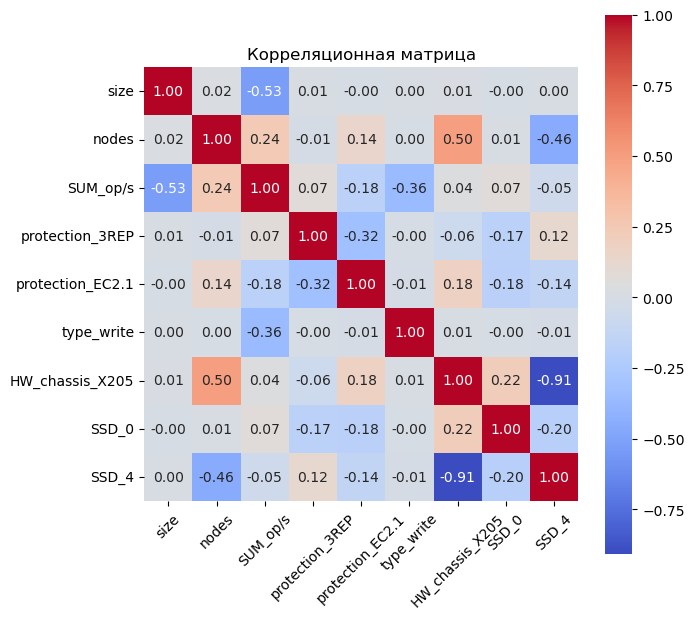

In [14]:
correlation_matrix = df.corr()
plt.figure(figsize=(7, 7))
hmap = sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
hmap.set_xticklabels(hmap.get_xmajorticklabels(), rotation=45)
plt.title('Корреляционная матрица')
plt.show()
sns.reset_orig()


**Вывод из матрицы корреляции**  
*Будем считать, что два признака кореллированы, если их коэффициент корреляции по модулю превосходит $0.7$.*  
Видно, что признаки `SSD` и `HW_chassis_X205` линейно зависимы, это объясняется тем, что замеры на `HW_chassis` = "X205" проводились при `SSD` = 2, а, замеры на `HW_chassis` = "VEGMAN" проводились при `SSD` = 4.  
Зависимость не значима.

## Data preprocessing

### Validation of raw data

#### Founder

Скрипт автоматически ищет ключи с несоответственным поведением таргет валью от изменений непрерывных параметров исходя из бизнес-логики.
Один проход скрипта, очевидно, не отыщет все корявые замеры - нужно итеративно проходиться, удаляя по пути найденые ошибки.

In [15]:
def founder(Data):
    '''
    Функция реально зависит только от Даты: именно состояние замеров в репе является ключевым объектом работы скрипта
    '''
    Broken_sizes = []

    for parametr in cont_params:

        doc_wout_param = copy.deepcopy(doc)

        doc_wout_param.pop(parametr)

        cross_doc = list(itertools.product(*list(doc_wout_param.values())))

        n = key_enum(parametr)
        cross_doc = [cross_doc[i][:n] + tuple([0]) + cross_doc[i][n:] for i in range(len(cross_doc))]

        cross_doc_dict = [
            {
                list(doc.keys())[i]: item[i] for i in range(len(list(doc.keys())))
            } for item in cross_doc

        ]  # костыльно добавляем нуль в валью парама, чтобы не изменять функцию compare

        for i in range(len(cross_doc_dict)):

            X = np.array([
                [tuple(Data[id]['parametrs'].values())[key_enum(parametr)], id] for id in list(Data.keys()) if compare(tuple(Data[id]['parametrs'].values()), parametr, cross_doc_dict[i])
                ], dtype=object)
            
            Y = np.array([
                Data[id]['values']['agregated']['SUM_op/s'] for id in list(Data.keys()) if compare(tuple(Data[id]['parametrs'].values()), parametr, cross_doc_dict[i])
                ], dtype=object)

            W = np.column_stack((X, Y))   # (cont., id, target value)
            if parametr == "nodes":
                W = W[W[:, 0].argsort()].T
            elif parametr == "size":
                #W = sorted(W, key=lambda item: item[0], reverse=True)
                W = W[W[:, 0].argsort()[::-1]].T  # ревёрсим массив для сайза, по БЛ при увеличении сайза, уменьшается таргеты
            for j in range(len(W[0]) - 1):
                if W[2][j] > W[2][j+1]:
                    if parametr == "nodes":
                        Broken_sizes.append(
                            W[1][j+1]
                        )
                    else:
                        Broken_sizes.append(
                            W[1][j+1]
                        )
                    # в broken_sizes хранятся айдишки

    return {"len": len(Broken_sizes), "broken_sizes": Broken_sizes}





#### Auto purifier
Скрипт удаляет все некорректные замеры.

In [16]:
def auto_cleaner(Data: dict) -> dict:
    Data_operated = Data.copy()
    removed_data = {}
    while founder(Data_operated)["len"] > 0:
        for id in founder(Data_operated)["broken_sizes"]:
            temp = Data_operated.pop(id, None)
            if temp is not None:
                removed_data[id] = temp['values']['agregated']["SUM_MB/s"]
    return {"data": Data_operated, "removed_data": removed_data}


Очистим нашу дату от ошибочных замеров

In [17]:
cleaned_data_temp = auto_cleaner(Data)  # вычислительно затратная функция, предпосчитаем её

In [18]:
df_cleaned = df_out.drop(index=list(cleaned_data_temp["removed_data"].keys()), inplace=False)

print(df_cleaned, '\n', f'removed {len(cleaned_data_temp["removed_data"])} points of data')


                                                                                  patch  \
ab2f1d60-8403-4e45-84d7-1c66a1bf4390           Correct sizes\Sizer results for rep3.txt   
68020565-e341-4e9f-a7d4-c746d6811023           Correct sizes\Sizer results for rep3.txt   
bda0db16-9462-4575-8d6e-e63f48c486de           Correct sizes\Sizer results for rep3.txt   
7e8e027a-ea15-4c49-8d50-9a110084c6b7           Correct sizes\Sizer results for rep3.txt   
8e13475e-ee49-4f8d-9adb-7123ad9fed27           Correct sizes\Sizer results for rep3.txt   
...                                                                                 ...   
293b2694-5f0e-44b3-a595-72f88418d485  Correct sizes\sizer_results_ec2.1_retest_actua...   
5d30ba05-ce67-4bb1-b13f-ea9f0fb062d5  Correct sizes\sizer_results_ec2.1_retest_actua...   
633391e0-ecd3-4d3b-a344-a07868690067  Correct sizes\sizer_results_ec2.1_retest_actua...   
82c63d5b-4deb-4a8f-a29b-6b8d9f730214  Correct sizes\sizer_results_ec2.1_retest_actua...   

#### Writer of broken sizes
можем записать в .xlsx то, что удалили

In [19]:
df_cleaned_to_out = df_out.loc[list(cleaned_data_temp["removed_data"].keys())]
df_cleaned_to_out.to_excel('broken_sizes.xlsx', index=False, header=True)
print(df_cleaned_to_out)


                                                                                 patch  \
b711eb24-0f41-42ca-99cd-3dda2d035141  Correct sizes\sizer_results_16nodes_rep2_12_0.md   
355fc84f-94d4-4bde-9902-f45e4ccdb02d  Correct sizes\sizer_results_16nodes_rep2_12_2.md   
576bf41c-aeee-4508-bf04-cb76a80e139f  Correct sizes\sizer_results_16nodes_rep2_12_2.md   
d1830155-8a96-48e9-b881-4b5f9a116265  Correct sizes\sizer_results_16nodes_rep2_12_2.md   
e81263e0-25a7-4de4-99de-bc312c240810  Correct sizes\sizer_results_16nodes_rep2_12_2.md   
...                                                                                ...   
a22b3911-a69f-4d9e-b879-5a857c115595  Correct sizes\sizer_results_16nodes_rep2_12_0.md   
2be2bfdf-34d8-4189-9151-5dee051ee800    Correct sizes\sizer_results_8nodes_rep2 (2).md   
c6c9a636-3c30-47fd-9df3-d54ee3855990                 Correct sizes\Sizer_results_1.txt   
701a0262-f3ef-4ee7-97dd-d7befc306a04  Correct sizes\sizer_results_16nodes_rep2_12_0.md   
1967e3b3-4

### Scaling

In [20]:
min_max_scaler = MinMaxScaler()
df_scaled = features_transformation(df_cleaned)
target_value = df_scaled.pop("SUM_op/s")
df_scaled = pd.DataFrame(min_max_scaler.fit_transform(df_scaled), columns=df_scaled.columns, index=df_scaled.index)
df_scaled = pd.concat([df_scaled, target_value], axis=1)
print(df_scaled)


                                          size  nodes  protection_3REP  \
ab2f1d60-8403-4e45-84d7-1c66a1bf4390  0.000000    1.0              1.0   
68020565-e341-4e9f-a7d4-c746d6811023  0.000000    1.0              1.0   
bda0db16-9462-4575-8d6e-e63f48c486de  0.000938    1.0              1.0   
7e8e027a-ea15-4c49-8d50-9a110084c6b7  0.000938    1.0              1.0   
8e13475e-ee49-4f8d-9adb-7123ad9fed27  0.007750    1.0              1.0   
...                                        ...    ...              ...   
293b2694-5f0e-44b3-a595-72f88418d485  0.000938    0.0              0.0   
5d30ba05-ce67-4bb1-b13f-ea9f0fb062d5  0.007750    0.0              0.0   
633391e0-ecd3-4d3b-a344-a07868690067  0.007750    0.0              0.0   
82c63d5b-4deb-4a8f-a29b-6b8d9f730214  1.000000    0.0              0.0   
f25fdc4b-0a3b-4130-81f5-2c8ddcf33250  1.000000    0.0              0.0   

                                      protection_EC2.1  type_write  \
ab2f1d60-8403-4e45-84d7-1c66a1bf4390     

C:\Users\shiri\AppData\Local\Temp\ipykernel_2316\3629461837.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_operational = df_operational.replace({True: 1, False: 0}).infer_objects(copy=False)


### Define weights
Проверим, какие фифчи влияют на таргет валью

In [21]:
M = LinearRegression()
header_temp_lr = list(df_scaled.loc[:, df_scaled.columns != 'SUM_op/s'].columns) + ['intercept']
x_lr = np.array(df_scaled.loc[:, df_scaled.columns != 'SUM_op/s'])
y_lr = np.array(df_scaled['SUM_op/s'])
M.fit(x_lr, y_lr)
weights = np.append(M.coef_, M.intercept_)
df_weights = pd.DataFrame(np.array(weights)).T
df_weights.columns = header_temp_lr
print(df_weights)


          size        nodes  protection_3REP  protection_EC2.1   type_write  \
0 -5752.982768  4920.031245        62.277954      -2074.571135 -2952.132711   

   HW_chassis_X205       SSD_0       SSD_4    intercept  
0     -1587.878416  847.735854 -425.557904  6939.812503  


### Visualization post-processed data

C:\Users\shiri\AppData\Local\Temp\ipykernel_2316\4286328807.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\shiri\AppData\Local\Temp\ipykernel_2316\4286328807.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\shiri\AppData\Local\Temp\ipykernel_2316\4286328807.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\shiri\AppData\Local\Temp\ipykernel_2316\4286328807.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.l

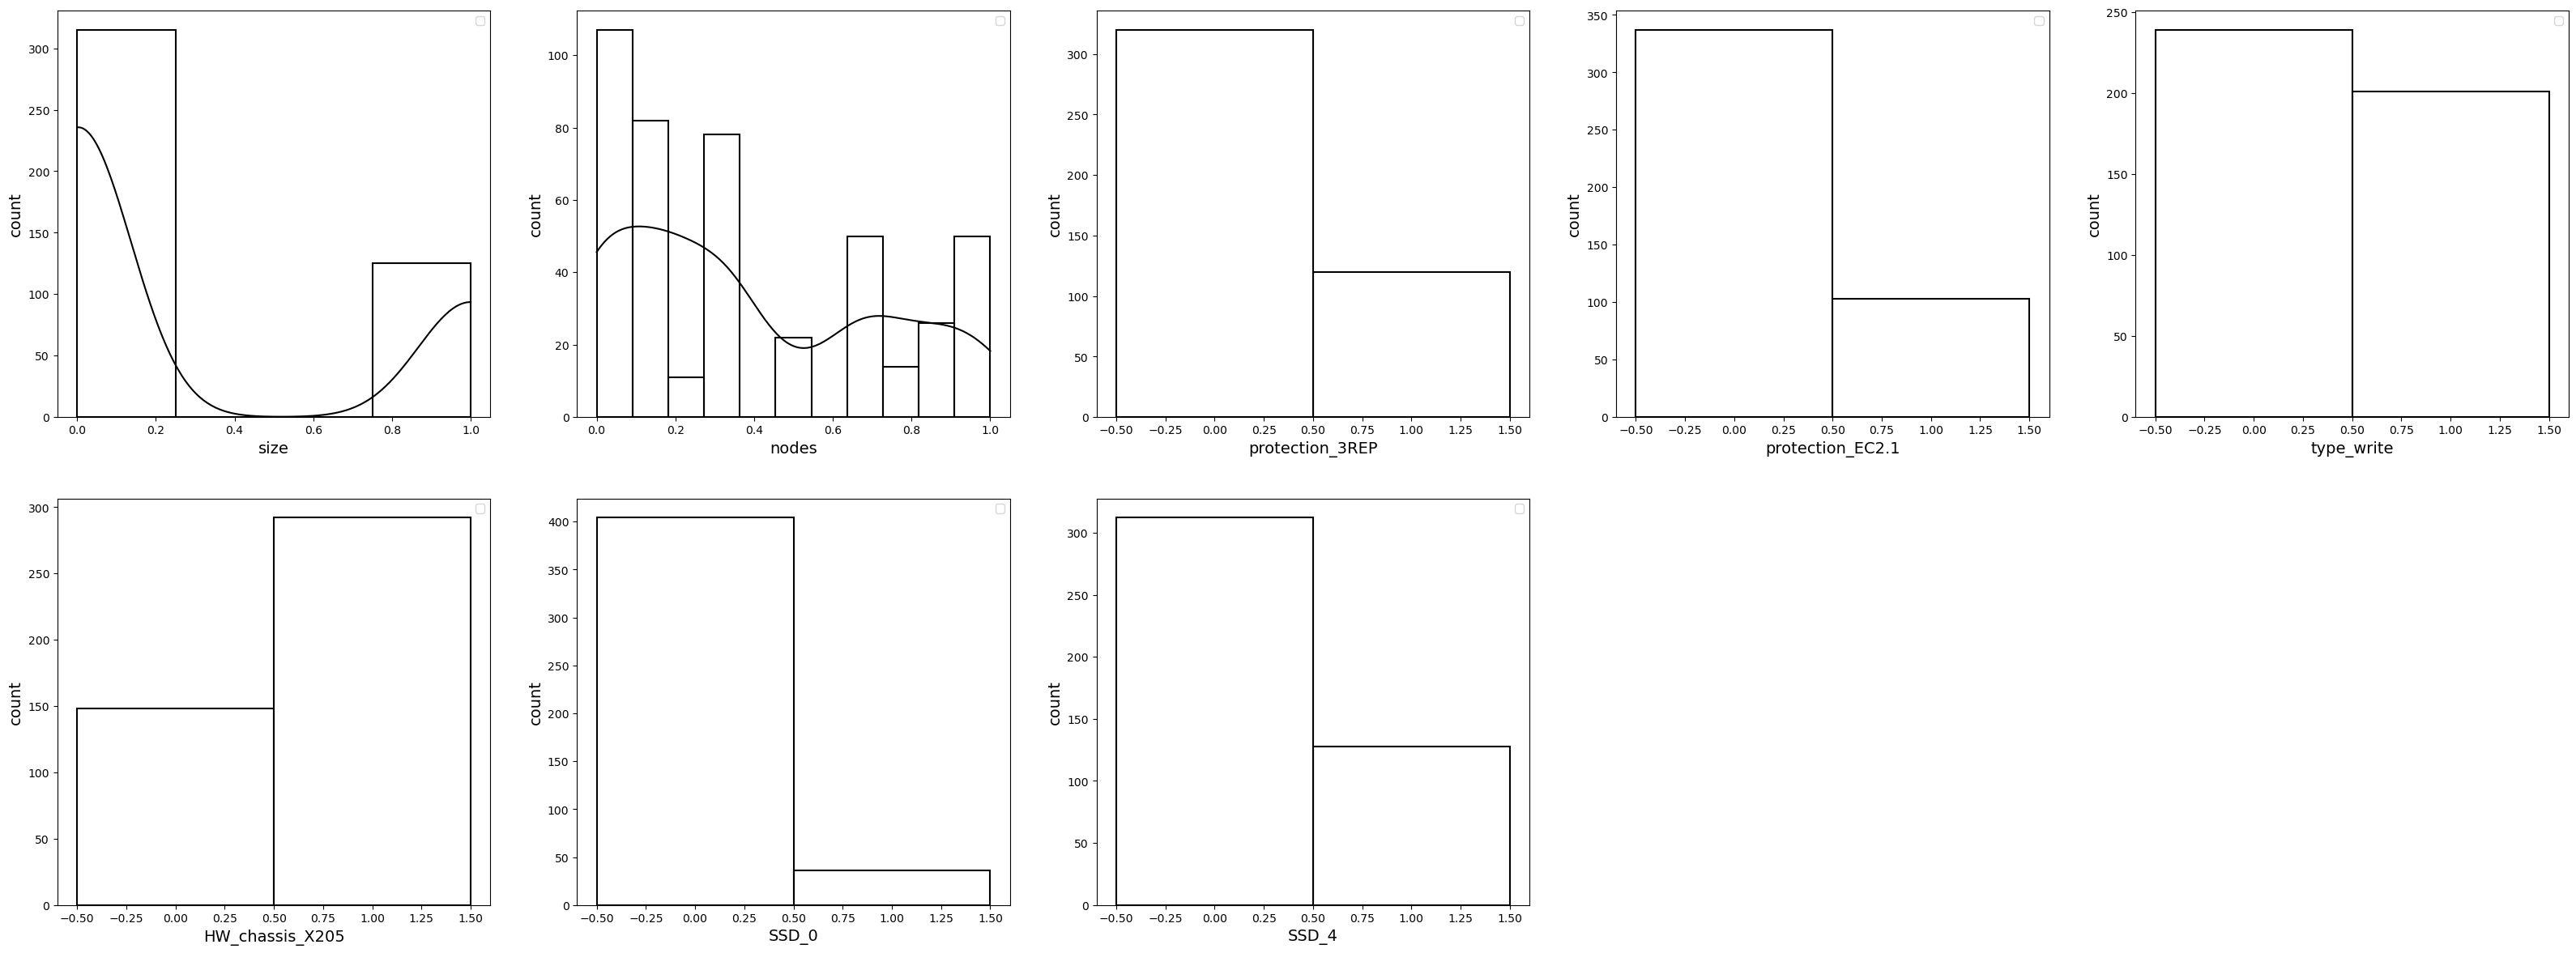

In [22]:
plt.figure(figsize=(40,30))
header_temp = list(df.columns)
header_temp.remove('SUM_op/s')
n = len(header_temp)

for i in range(n):
    plt.subplot(n // 2, n - n // 2 + 1,i + 1)
    #X = list(df_scaled[header_temp[i]] if (header_temp[i] != 'size') else df_scaled[header_temp[i]].apply(lambda x: np.log(x+1)))
    X = list(df_scaled[header_temp[i]])
    Y = list(df_scaled['SUM_op/s'])
    n_bins = len(list(df_scaled[header_temp[i]].unique()))
    cont_switch = True if ((header_temp[i] in cont_params)) else False 
    his = sns.histplot(X, bins=n_bins, color='k', kde=cont_switch, fill=False, discrete=(not cont_switch))
    plt.title('', fontsize=15)
    plt.xlabel(header_temp[i], fontsize=14, color='k')
    plt.ylabel('count', fontsize=14, color='k')
    plt.legend()
plt.show()
sns.reset_orig()

#### Correlation matrix
смотрим на матрицу корреляции после валидации даты

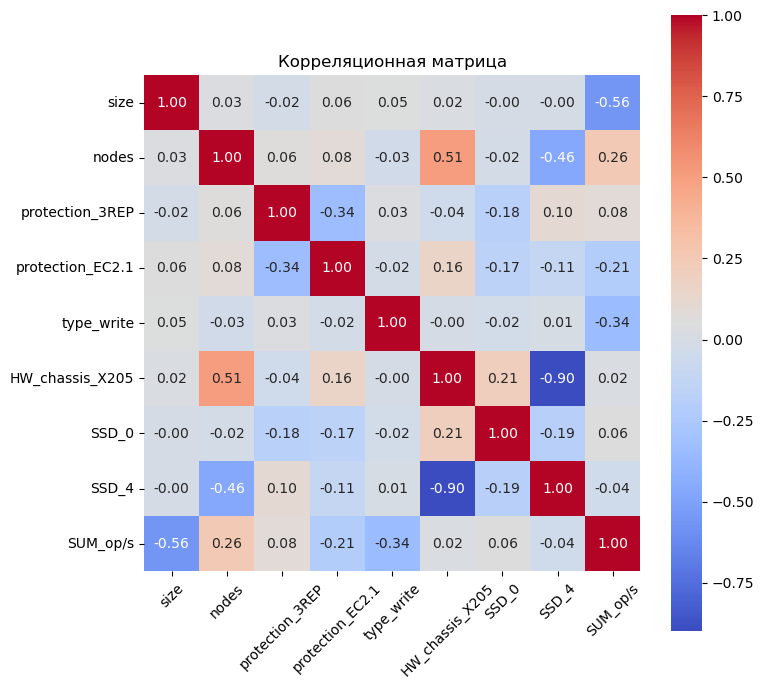

In [23]:
df_temp = df_scaled.copy()
df_temp.drop('SUM_op/s', axis=1)
correlation_matrix = df_temp.corr()
plt.figure(figsize=(8, 8))
hmap = sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
hmap.set_xticklabels(hmap.get_xmajorticklabels(), rotation=45)
plt.title('Корреляционная матрица')
plt.show()
sns.reset_orig()


видим, что корр в среднем уменьшился

#### Graphs

In [24]:
parametr = 'nodes'
'''
It's an Ox' value
(Oy always is a target value --- perfomance)
'''

### fix other params for detail searching (order as in documentation dictionary - it`s important)
fix_params = {
    'protection': '2REP',
    'size': 128000,
    'nodes': 4,
    'type': 'write',
    'HW_chassis': 'X205',
    'SSD': 2
}
### we can define here other pack of params for compare
fix_params_2 = {
    'protection': '3REP',
    'size': 8,
    'nodes': 8,
    'type': 'write',
    'HW_chassis': 'VEGMAN',
    'SSD': 4
}
###

params:
           first graph second graph
protection        2REP         3REP
size            128000            8
type             write        write
HW_chassis        X205       VEGMAN
SSD                  2            4


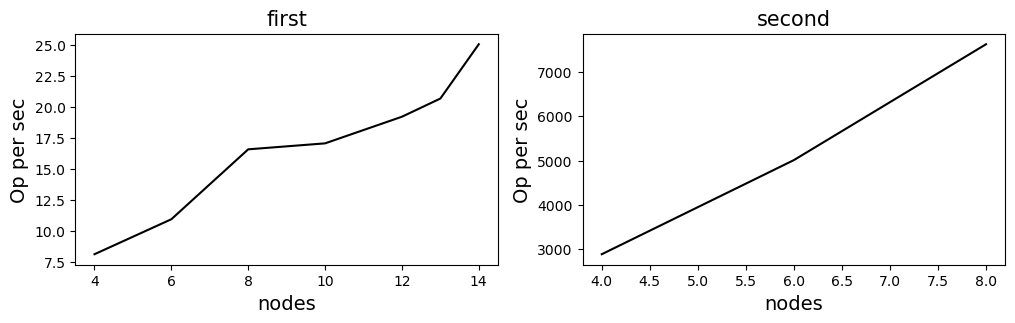

In [25]:
indeces = Counter([key[1] for key in list(Data.keys())])

Data_cleaned = copy.deepcopy(cleaned_data_temp["data"])

W = {
    list(Data_cleaned[id]['parametrs'].values())[key_enum(parametr)]: Data_cleaned[id]['values']['agregated']['SUM_op/s'] for id in list(Data_cleaned.keys()) if compare(list(Data_cleaned[id]['parametrs'].values()), parametr, fix_params_2)
}

W = np.array([
    [key, W[key]] for key in list(W.keys())
]).T


Z = {
    list(Data_cleaned[id]['parametrs'].values())[key_enum(parametr)]: Data_cleaned[id]['values']['agregated']['SUM_op/s'] for id in list(Data_cleaned.keys()) if compare(list(Data_cleaned[id]['parametrs'].values()), parametr, fix_params)
}

Z = np.array([
    [key, Z[key]] for key in list(Z.keys())
]).T

Z = Z[Z[:, 0].argsort()].T; W = W[W[:, 0].argsort()].T

plt.figure(figsize=(12, 3)) 

plt.subplot(1, 2, 1)
plt.xscale('linear')

Z = Z[Z[:, 0].argsort()].T; W = W[W[:, 0].argsort()].T
graph_title = {key: {'first graph': fix_params[key], 'second graph': fix_params_2[key]} for key in list(doc.keys())}

plt.plot(Z[0], Z[1],'k-', alpha = 1)
graph_title.pop(parametr, None)
print(f'params:\n{pd.DataFrame(graph_title).transpose()}')
plt.title('first', fontsize=15)
plt.xlabel(parametr, fontsize=14, color='k')
plt.ylabel('Op per sec', fontsize=14, color='k')


plt.subplot(1, 2, 2)
plt.xscale('linear')
plt.plot(W[0], W[1],'k-', alpha = 1)
plt.title('second', fontsize=15)
plt.xlabel(parametr, fontsize=14, color='k')
plt.ylabel('Op per sec', fontsize=14, color='k')
plt.show()


Из графиков выше, мы должны понять характер роста производительности

## Modelling

_about_: использованы байесовские методы из PyMC.

**Архитектура модели**

у нас есть `cleaned_data_temp["data"]` структуры, идентичной, струкуре `Data`, описаной в документации.

1. обучаем $|"protection"|\cdot|"size"|\cdot|"type"|\cdot|"HW\_chassis"|\cdot|"SSD"|$ моделей вида:
$$\hat{y} = w_1 \cdot \log("nodes") + w_2 \cdot "nodes" + w_{intercept}$$

``` python
Lines = {
    id: line_body
}
id = "line-" + str(uuid.uuid4())
```

``` json
line_body: {
    "parametrs": {
        "protection": "str",
        "size": "int",
        "nodes": "int",
        "type": "str",
        "HW_chassis": "str",
        "SSD": "int"
    },
    "SUM_op/s": "int"
}
```



Таким образом, создаётся сетка данных: `cleaned_data_temp["data"]` $\cup\;("nodes", "other_features"\;|\;"nodes"\in [4,100])$ 


In [339]:
Lines = {}
line_body_template = {
    "parametrs": {
        "protection": None,
        "size": None,
        "nodes": None,
        "type": None,
        "HW_chassis": None,
        "SSD": None
    },
    "SUM_op/s": None,
    "metrics": {
        "R2": None,
        "RRMSE": None
    },
    "weights": {
        "linear": None,
        "log": None,
        "intercept": None
    }
}

df_raw_params = df_cleaned[["protection", "size", "nodes", "type", "HW_chassis", "SSD"]]
domain = np.linspace(4, 100, 97, dtype=int)
df_raw_params = df_raw_params.drop_duplicates()  # все парамы из замеров

for row in np.array(df_raw_params):
    fix_params = dict(zip(list(df_raw_params.columns),row))

    Z = {
        list(Data_cleaned[id]['parametrs'].values())[key_enum("nodes")]: Data_cleaned[id]['values']['agregated']['SUM_op/s'] for id in list(Data_cleaned.keys()) if compare(tuple(Data_cleaned[id]['parametrs'].values()), "nodes", fix_params)
    }
    Z = np.array([list(item) for item in list(Z.items())])

    Z = Z[Z[:, 0].argsort()].T
    X = Z[0] # nodes
    X = np.array([[X[i], np.log(X[i])] for i in range(len(X))]) # after coordinates transf
    Y = np.array(Z[1])  # target value
    #temp_model = LinearRegression()
    temp_model = Ridge(alpha=0.1)
    temp_model.fit(X, Y)
    
    predictions = np.array([temp_model.predict([x])[0] for x in X])
    rrmse = np.sqrt(np.sum((predictions - Y) ** 2) / len(Y)) / np.mean(Y) * 100
    r2 = temp_model.score(X, Y)

    for n in range(4, 101):
        id_line = "line-" + str(uuid.uuid4())
        body = copy.deepcopy(line_body_template)
        fix_params_t = copy.deepcopy(fix_params)
        fix_params_t["nodes"] = n
        Lines[id_line] = body
        Lines[id_line]["parametrs"] = fix_params_t
        value = temp_model.predict([[n, np.log(n)]])
        Lines[id_line]["metrics"]["R2"] = r2
        Lines[id_line]["metrics"]["RRMSE"] = rrmse
        Lines[id_line]["weights"]["linear"] = temp_model.coef_[0]
        Lines[id_line]["weights"]["log"] = temp_model.coef_[1]
        Lines[id_line]["weights"]["intercept"] = temp_model.intercept_

        Lines[id_line]["SUM_op/s"] = value[0]


c:\Users\shiri\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\shiri\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


### Vizualization of linear predictors
на предыдущем шаге построили линейные модели для каждого набора параметров, теперь можем изобразить предсказанные значения

params:
              info
protection   EC2.1
size           128
type         write
HW_chassis  VEGMAN
SSD              4
R2            0.85
RRMSE         6.21


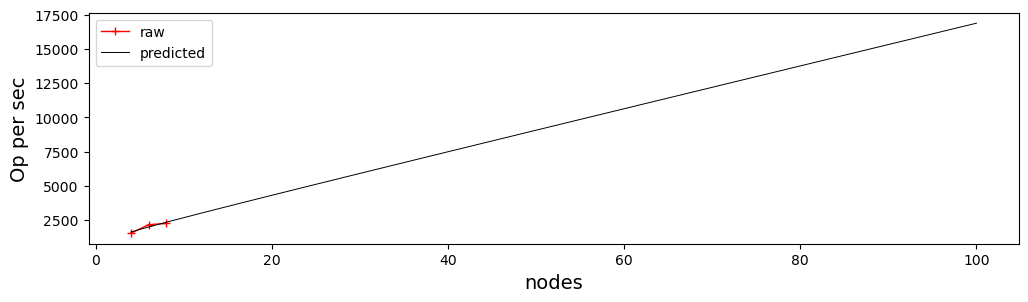

In [340]:
parametr = 'nodes'

fix_params = {
    'protection': 'EC2.1',
    'size': 128,
    'nodes': 4,
    'type': 'write',
    'HW_chassis': 'VEGMAN',
    'SSD': 4,
}

Data_cleaned = copy.deepcopy(cleaned_data_temp["data"])

W = {
    list(Lines[id]['parametrs'].values())[key_enum(parametr)]: Lines[id]['SUM_op/s'] for id in list(Lines.keys()) if compare(list(Lines[id]['parametrs'].values()), parametr, fix_params)
}
W = np.array([list(item) for item in list(W.items())])
Z = {
    list(Raw_Data[id]['parametrs'].values())[key_enum(parametr)]: Raw_Data[id]['values']['agregated']['SUM_op/s'] for id in list(Raw_Data.keys()) if compare(list(Raw_Data[id]['parametrs'].values()), parametr, fix_params)
}
Z = np.array([list(item) for item in list(Z.items())])

Z = Z[Z[:, 0].argsort()].T; W = W[W[:, 0].argsort()].T

plt.figure(figsize=(12, 3)) 


R_sq = ["%.2f" % Lines[id]['metrics']["R2"] for id in list(Lines.keys()) if compare(list(Lines[id]['parametrs'].values()), parametr, fix_params)][0]
RRMSE = ["%.2f" % Lines[id]['metrics']["RRMSE"] for id in list(Lines.keys()) if compare(list(Lines[id]['parametrs'].values()), parametr, fix_params)][0]
graph_title = {key: {'info': fix_params[key]} for key in list(doc.keys())} | {"R2": {"info": R_sq}, "RRMSE": {"info": RRMSE}}

plt.plot(Z[0], Z[1],'red', alpha = 1, label="raw", linestyle='-', linewidth=1, marker='+', markersize=6)
plt.plot(W[0], W[1],'black', alpha = 1, label="predicted", linestyle='-', linewidth=0.7)
graph_title.pop(parametr, None)
print(f'params:\n{pd.DataFrame(graph_title).transpose()}')
plt.xlabel(parametr, fontsize=14, color='k')
plt.ylabel('Op per sec', fontsize=14, color='k')
plt.legend()
plt.show()
#print(f'Z={Z}','\n', f'W={W}')


In [262]:
print([Lines[id] for id in list(Lines.keys())][:2])

[{'parametrs': {'protection': '3REP', 'size': 8, 'nodes': 4, 'type': 'write', 'HW_chassis': 'X205', 'SSD': 2}, 'SUM_op/s': 2465.889752033099, 'metrics': {'R2': 0.9998421939648385, 'RRMSE': 0.5540000951326249}, 'weights': {'linear': 582.5952646017787, 'log': 146.08762192492082, 'intercept': -67.01175287794831}}, {'parametrs': {'protection': '3REP', 'size': 8, 'nodes': 5, 'type': 'write', 'HW_chassis': 'X205', 'SSD': 2}, 'SUM_op/s': 3081.0835273942516, 'metrics': {'R2': 0.9998421939648385, 'RRMSE': 0.5540000951326249}, 'weights': {'linear': 582.5952646017787, 'log': 146.08762192492082, 'intercept': -67.01175287794831}}]


### Training

#### Preparing data
Теперь, подготовим дату к обучению

In [342]:
print(min([Lines[id]["metrics"]["R2"] for id in list(Lines.keys())]))

0.8055028849562742


In [291]:
Raw_Data = copy.deepcopy(Data_cleaned)
U_Data = Lines | Raw_Data


In [348]:
header_df = list(doc.keys()) + ["SUM_op/s"]
df_Lines = pd.DataFrame([list((Lines[id]["parametrs"] | {"SUM_op/s": Lines[id]["SUM_op/s"]}).values()) for id in list(Lines.keys())], columns=header_df, index=list(Lines.keys()))
df_cleaned_U = features_transformation(df_Lines)

C:\Users\shiri\AppData\Local\Temp\ipykernel_2316\3629461837.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_operational = df_operational.replace({True: 1, False: 0}).infer_objects(copy=False)


In [365]:
X = df_cleaned_U.drop("SUM_op/s", axis=1)
Y = df_cleaned_U["SUM_op/s"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Model = RandomForestRegressor(n_estimators=100)
Model.fit(X_train, Y_train)

Y_pred = Model.predict(X_test)

rrmse = np.sqrt(mean_squared_error(Y_test, Y_pred)) / np.mean(Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f'RRMSE: {rrmse}','\n',f'R2: {r2}')

RRMSE: 0.005001594731287312 
 R2: 0.9999852802000831


### Visualization predicted data

C:\Users\shiri\AppData\Local\Temp\ipykernel_2316\3629461837.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_operational = df_operational.replace({True: 1, False: 0}).infer_objects(copy=False)
c:\Users\shiri\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\shiri\AppData\Local\Temp\ipykernel_2316\3629461837.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_operational = df_op

params:
            info
protection  3REP
size         128
type        read
HW_chassis  X205
SSD            2


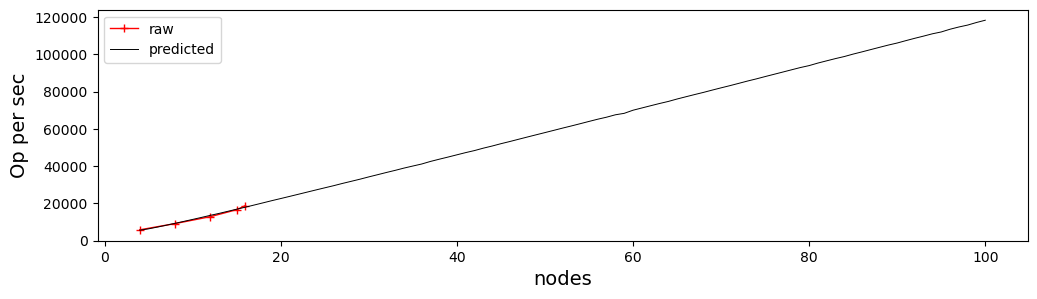

In [370]:
parametr = 'nodes'

fix_params = {
    'protection': '3REP',
    'size': 128,
    'nodes': 4,
    'type': 'read',
    'HW_chassis': 'X205',
    'SSD': 2,
    'SUM_op/s': 0  # костыль
}

predict = {}

for n in range(4, 101):
    params_temp = copy.deepcopy(fix_params)
    params_temp["nodes"] = n
    key = str(uuid.uuid4())
    df_predicted = features_transformation(pd.DataFrame(params_temp, index=[key]))
    X = df_predicted.drop("SUM_op/s", axis=1).values.tolist()
    predict[n] = Model.predict(X)[0]

# predicted
W = np.array([list(item) for item in list(predict.items())])
W = W[W[:, 0].argsort()].T
#
fix_params.pop("SUM_op/s")
# raw
Z = {
    list(Raw_Data[id]['parametrs'].values())[key_enum(parametr)]: Raw_Data[id]['values']['agregated']['SUM_op/s'] for id in list(Raw_Data.keys()) if compare(list(Raw_Data[id]['parametrs'].values()), parametr, fix_params)
}
Z = np.array([list(item) for item in list(Z.items())])
Z = Z[Z[:, 0].argsort()].T
#

plt.figure(figsize=(12, 3)) 

graph_title = {key: {'info': fix_params[key]} for key in list(doc.keys())}

plt.plot(Z[0], Z[1],'red', alpha = 1, label="raw", linestyle='-', linewidth=1, marker='+', markersize=6)
plt.plot(W[0], W[1],'black', alpha = 1, label="predicted", linestyle='-', linewidth=0.7)
graph_title.pop(parametr, None)
print(f'params:\n{pd.DataFrame(graph_title).transpose()}')
plt.xlabel(parametr, fontsize=14, color='k')
plt.ylabel('Op per sec', fontsize=14, color='k')
plt.legend()
plt.show()
#print(f'Z={Z}','\n', f'W={W}')


### Metrics

## Summaries

## TODO

* посмотреть на разброс прогноза в интересующих нас точках и на зависимость этого разброса от модели и априорных распределений
    * построить интервалы для предсказаний в далеких точках и увидеть, что они слишком широкие
* рассмотреть несколько моделей
* провалидировать имеющиеся модели
* ошибки моделируются с помощью нормального распределения - пересмотреть эту позицию, предлагается: t - Стьюдент с 5 степенями свобод
* mu = (a * x[:, 0] + b * x[:,1]) * (c * x[:,2] + d) - изменить тип модели